In [1]:
#check versions

import sys
print(sys.version)

#conda list
#https://charlesreid1.github.io/empirical-model-building/factorial_2level_6factor.html#computing_effects

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#conda list

In [3]:
import matplotlib.style as style
#style.use('seaborn-darkgrid')
style.use('seaborn-paper')

import pandas as pd
import numpy as np
import os
import csv
from csv import reader
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import rand, seed
import scipy.stats as stats
import pyDOE2 as doe2
%matplotlib inline
from numpy.random import rand, seed
import statsmodels.api as sm
import numpy as np
import itertools
import warnings
warnings.simplefilter(action='ignore')

In [4]:
def do_screen(postanalysis,label_list):
    # Create the inputs:
    encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]) )

    # Create the experiment design table:
    doe = pd.DataFrame(encoded_inputs,columns=label_list) #['x%d'%(i+1) for i in range(8)])

    design = doe2.ff2n(8)

    shape = np.shape(design)

    init_list = []
    altkey = []
    def signeval(check):
        if check == -1:
            result = 'm'
        elif check == 1:
            result = 'p'
        else: 
            result = 'fail'
        return result

    for i in range(shape[0]):
        string1 = 'init(5,1,1,3,3,3,'
        string2 = 'A' + signeval(design[i][0]) + ','
        string3 = 'B' + signeval(design[i][1]) + ','
        string4 = 'C' + signeval(design[i][2]) + ','
        string5 = 'D' + signeval(design[i][3]) + ','
        string6 = 'E' + signeval(design[i][4]) + ','
        string7 = 'F' + signeval(design[i][5]) + ','
        string8 = 'G' + signeval(design[i][6]) + ','
        string9 = 'H' + signeval(design[i][7]) + ','
        string10 = ''
        if string2[1] == 'p':
            string10 = 'a'
            key2 = '1'
        else:
            key2='-1'
        if string3[1] == 'p':
            string10 = string10 + 'b'
            key3 = '1'
        else:
            key3='-1'
        if string4[1] == 'p':
            key4 = '1'
            string10 = string10 + 'c'
        else:
            key4='-1'
        if string5[1] == 'p':
            string10 = string10 + 'd'
            key5 = '1'
        else:
            key5='-1'
        if string6[1] == 'p':
            string10 = string10 + 'e'
            key6 = '1'
        else:
            key6='-1'
        if string7[1] == 'p':
            string10 = string10 + 'f'
            key7 = '1'
        else:
            key7='-1'
        if string8[1] == 'p':
            string10 = string10 + 'g'
            key8 = '1'
        else:
            key8='-1'
        if string9[1] == 'p':
            string10 = string10 + 'h'
            key9 = '1'
        else:
            key9='-1'
        altkey.append(string10)#,key2,key3,key4,key5,key6,key7,key8,key9])
        string10 = '\'{}\')'.format(string10)
        strung = string1 + string2 + string3 + string4 + string5 + string6 + string7 + string8 + string9 + string10

    fileList = os.listdir(str(postanalysis)) #Read files in folder into list 

    treatments = []
    for file in fileList: #Loop through list of files using file as identifier
        path = postanalysis+ '/' 
        if file == fileList[0]:
            split_file_name = file.split("_")
            with open(path+file, newline='') as f:
                reader = csv.reader(f)
                read = []
                for row in reader:
                    read.append(row)
                first = read[0][0]
                last = read[-1][-1]
                Response_Variable = float(last) - float(first)
                treatments.append([split_file_name[0],Response_Variable])
        else:
            split_file_name = file.split("_")
            with open(path+file, newline='') as f:
                reader = csv.reader(f)
                read = []
                for row in reader:
                    read.append(row)
                first = read[0][0]
                last = read[-1][-1]
                Response_Variable = float(last) - float(first)
                treatments.append([split_file_name[0],Response_Variable])

    treatment_df = pd.DataFrame(treatments,columns=['Treatment','ResponseVariable'])
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    
    doe[postanalysis]  = doe[str(label_list[0])]*0
    doe['Designation']  = doe[str(label_list[0])]*0
    
    for i in range(1,len(doe)):
        #Read treat_var from doe 
        treat_var = translate(doe.iloc[i,0],doe.iloc[i,1],doe.iloc[i,2],doe.iloc[i,3],doe.iloc[i,4],doe.iloc[i,5],doe.iloc[i,6],doe.iloc[i,7]) 
        #Lookup treat_var from treatment ResponseVariabe 
        queried_treat_var = treatment_df.query ("Treatment==@treat_var").iloc[0,1]
        # Write Response Variable to doe location i
        doe.iloc[i,8] = queried_treat_var
        doe.iloc[i,9] = treat_var

    doe.iloc[0,8] = treatment_df.query('Treatment=="one"').iloc[0,1]
    doe.iloc[0,9] = 'one'
    
    labels = {}
    labels[1] = label_list 
    for i in [2,3,4,5,6,7,8]:
        labels[i] = list(itertools.combinations(labels[1],i))

    obs_list = [postanalysis]

    effects = {}
    effects[0] = {'x0' : [doe[postanalysis].mean()]}
    
    effects[1] = {}
    for key in labels[1]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby(key)[obs].mean()
            result = sum([ zz*effects_df.loc[zz] for zz in effects_df.index ])
            effects_result.append(result)
        effects[1][key] = effects_result

    for c in [2,3,4,5,6,7,8]:
        effects[c] = {}
        for key in labels[c]:
            effects_result = []
            for obs in obs_list:
                effects_df = doe.groupby(key)[obs].mean()
                result = sum([ np.prod(zz)*effects_df.ix[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
                effects_result.append(result)
            effects[c][key] = effects_result
    master_dict = {}
    for nvars in effects.keys():

        effect = effects[nvars]
        for k in effect.keys():
            v = effect[k]
            master_dict[k] = v

    master_df = pd.DataFrame(master_dict).T
    master_df.columns = obs_list
    return master_df


In [5]:
def translate(a,b,c,d,e,f,g,h):
    if a > 0:
        string_a = 'a'
    else:
        string_a = ''
    if b > 0:
        string_b = 'b'
    else:
        string_b = ''
    if c > 0:
        string_c = 'c'
    else:
        string_c = ''
    if d > 0:
        string_d = 'd'
    else:
        string_d = ''
    if e > 0:
        string_e = 'e'
    else:
        string_e = ''
    if f > 0:
        string_f = 'f'
    else:
        string_f = ''
    if g > 0:
        string_g = 'g'
    else:
        string_g = ''       
    if h > 0:
        string_h = 'h'
    else:
        string_h = ''  
    return str(string_a + string_b + string_c + string_d + string_e + string_f + string_g + string_h) 

In [6]:
temp_list = [0,5,15,25,35]
press_list = [1000,1500,2000,2500] # 1000,1500,2000,2500]
label_list = ['Wo','ads_k','ads_ns','ads_cp','E0_beta','Ea','ads_dps','Du0']

df_list = []
for temp in temp_list:
    for press in press_list:
        df_list.append('df_' + str(press) + 'pp_' + str(temp) + 'del')

for dataframe in df_list:
    if dataframe == df_list[0]:
        print('\n Processing . . . . . ' , dataframe )
        pp = dataframe[10:12]
        t_del = int(dataframe[3:7])
        pp = int(pp.replace('d',''))
        meta_df = do_screen(dataframe[3:],label_list)     
        meta_df.loc[len(meta_df.index)] = [t_del]
        meta_df.loc[len(meta_df.index)] = [pp]
        

    else:
        print('Processing . . . . . ' , dataframe)
        pp = dataframe[10:12]        
        t_del = int(dataframe[3:7])
        pp = int(pp.replace('d',''))
        iter_df = do_screen(dataframe[3:],label_list)             
        iter_df.loc[len(iter_df.index)] = [t_del]
        iter_df.loc[len(iter_df.index)] = [pp]
        
        meta_df = meta_df.join(iter_df, how='outer')


 Processing . . . . .  df_1000pp_0del
Processing . . . . .  df_1500pp_0del
Processing . . . . .  df_2000pp_0del
Processing . . . . .  df_2500pp_0del
Processing . . . . .  df_1000pp_5del
Processing . . . . .  df_1500pp_5del
Processing . . . . .  df_2000pp_5del
Processing . . . . .  df_2500pp_5del
Processing . . . . .  df_1000pp_15del
Processing . . . . .  df_1500pp_15del
Processing . . . . .  df_2000pp_15del
Processing . . . . .  df_2500pp_15del
Processing . . . . .  df_1000pp_25del
Processing . . . . .  df_1500pp_25del
Processing . . . . .  df_2000pp_25del
Processing . . . . .  df_2500pp_25del
Processing . . . . .  df_1000pp_35del
Processing . . . . .  df_1500pp_35del
Processing . . . . .  df_2000pp_35del
Processing . . . . .  df_2500pp_35del


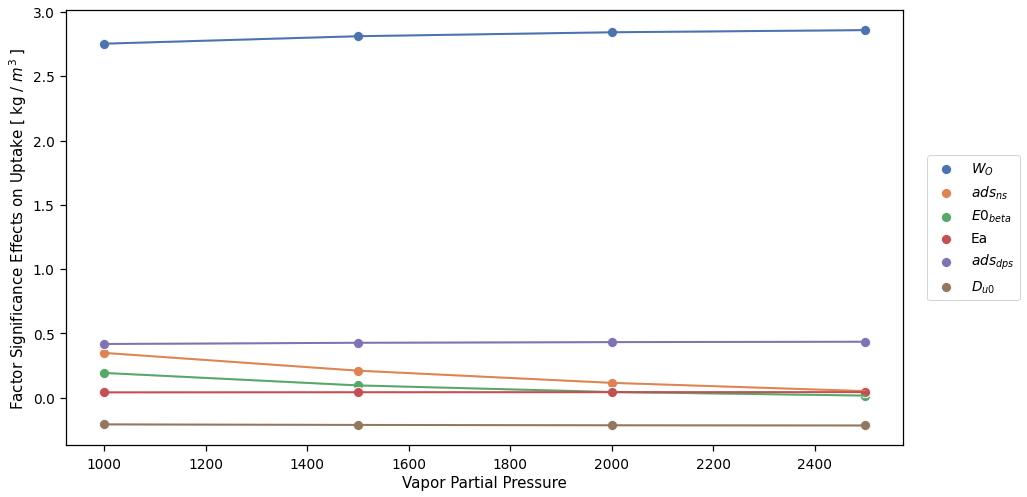

In [29]:
plt.figure(figsize=(15,8))
sns.set(style=None, font_scale=1.25)

sns.lineplot(y=data.Wo, x=data[256],linewidth=2)
sns.scatterplot(y=data.Wo, x=data[256], label='$W_O$', marker='o', s=100)

sns.lineplot(y=data.ads_ns, x=data[256],linewidth=2)
sns.scatterplot(y=data.ads_ns, x=data[256], label='$ads_{ns}$', marker='o',s=100)

sns.lineplot(y=data.E0_beta, x=data[256],linewidth=2)
sns.scatterplot(y=data.E0_beta, x=data[256], label='$E0_{beta}$', marker='o',s=100)

sns.lineplot(y=data.Ea, x=data[256],linewidth=2)
sns.scatterplot(y=data.Ea, x=data[256], label='Ea', marker='o',s=100)

sns.lineplot(y=data.ads_dps, x=data[256],linewidth=2)
sns.scatterplot(y=data.ads_dps, x=data[256], label='$ads_{dps}$', marker='o',s=100)

sns.lineplot(y=data.Du0, x=data[256],linewidth=2)
sns.scatterplot(y=data.Du0, x=data[256], label='$D_{u0}$', marker='o',s=100)
#plt.ylim([0,.5])
plt.ylabel('Factor Significance Effects on Uptake [ kg / $m^3$ ]')
plt.xlabel('Vapor Partial Pressure')
plt.legend(loc='center left', bbox_to_anchor = (1.02,.5), ncol=1)

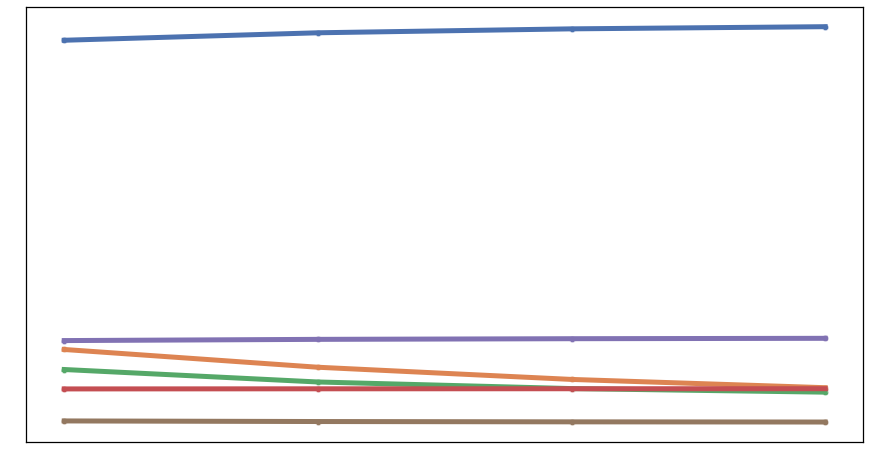

In [11]:
plt.figure(figsize=(15,8))
sns.set(style=None, font_scale=1.25)

sns.lineplot(y=data.Wo, x=data[256],linewidth=5)
sns.scatterplot(y=data.Wo, x=data[256], label='$W_O$')

sns.lineplot(y=data.ads_ns, x=data[256],linewidth=5)
sns.scatterplot(y=data.ads_ns, x=data[256], label='$ads_{ns}$')

sns.lineplot(y=data.E0_beta, x=data[256],linewidth=5)
sns.scatterplot(y=data.E0_beta, x=data[256], label='$E0_{beta}$')

sns.lineplot(y=data.Ea, x=data[256],linewidth=5)
sns.scatterplot(y=data.Ea, x=data[256], label='Ea')

sns.lineplot(y=data.ads_dps, x=data[256],linewidth=5)
sns.scatterplot(y=data.ads_dps, x=data[256], label='$ads_{dps}$')

sns.lineplot(y=data.Du0, x=data[256],linewidth=5)
sns.scatterplot(y=data.Du0, x=data[256], label='$D_{u0}$')
plt.tick_params(
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend().remove() 

Text(0.5, 0, 'Vapor Partial Pressure')

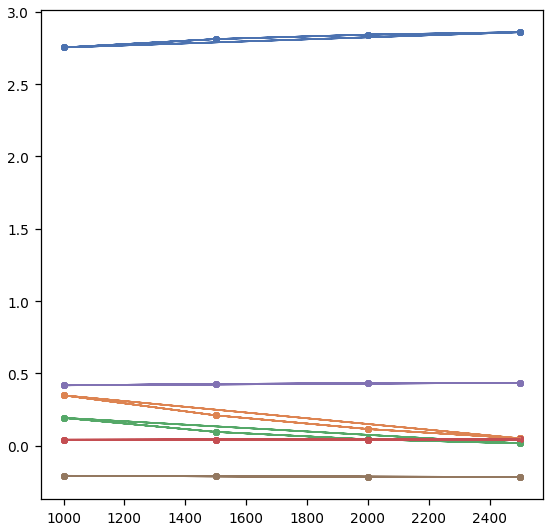

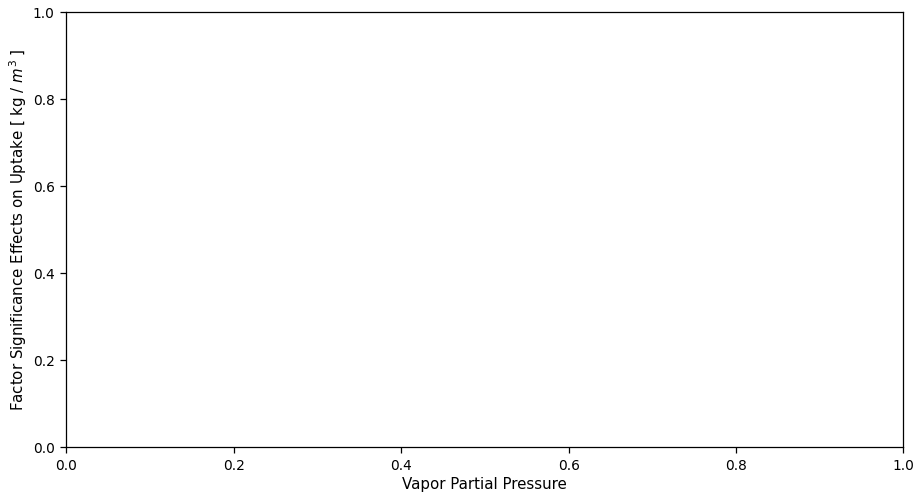

In [12]:

fig, ax1 = plt.subplots()
fig.set_size_inches([9,9])
plt.figure(figsize=(15,8))

sns.set(style=None, font_scale=1.25)
x=data[256]

ax1.plot(x, data.Wo)
ax1.scatter(x, data.Wo, label='$W_O$')

ax1.plot(x, data.ads_ns)
ax1.scatter(x,data.ads_ns, label='$ads_{ns}$')

ax1.plot(x,data.E0_beta)
ax1.scatter(x,data.E0_beta, label='$E0_{beta}$')

ax1.plot(x,data.Ea)
ax1.scatter(x,data.Ea, label='Ea')

ax1.plot(x,data.ads_dps)
ax1.scatter(x,data.ads_dps, label='$ads_{dps}$')

ax1.plot(x,data.Du0)
ax1.scatter(x,data.Du0, label='$D_{u0}$')

ax2.plot(x, data.ads_ns)
ax2.scatter(x,data.ads_ns, label='$ads_{ns}$')

ax2.plot(x,data.E0_beta)
ax2.scatter(x,data.E0_beta, label='$E0_{beta}$')

ax2.plot(x,data.Ea)
ax2.scatter(x,data.Ea, label='Ea')

ax2.plot(x,data.ads_dps)
ax2.scatter(x,data.ads_dps, label='$ads_{dps}$')

ax2.plot(x,data.Du0)
ax2.scatter(x,data.Du0, label='$D_{u0}$')
plt.ylabel('Factor Significance Effects on Uptake [ kg / $m^3$ ]')
plt.xlabel('Vapor Partial Pressure')
#plt.legend(loc='center left', bbox_to_anchor = (1.02,.5), ncol=1)


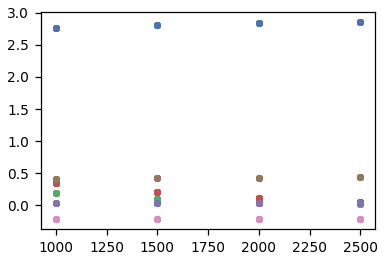

In [13]:
scatter(data[256], data.Wo)
scatter(data[256], data.ads_ns)
scatter(data[256], data.E0_beta)
scatter(data[256], data.ads_ns)
scatter(data[256], data.Ea)
scatter(data[256], data.ads_dps)
scatter(data[256], data.Du0)

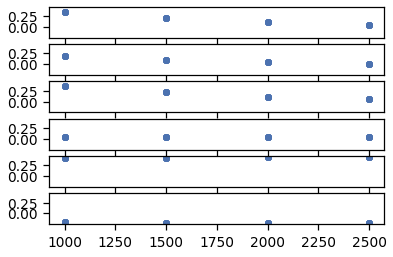

In [14]:
fig, axs = plt.subplots(6, sharex=True, sharey=True)
#fig.suptitle('Sharing both axes')
axs[0].scatter(data[256], data.ads_ns)
axs[1].scatter(data[256], data.E0_beta)
axs[2].scatter(data[256], data.ads_ns)
axs[3].scatter(data[256], data.Ea)
axs[4].scatter(data[256], data.ads_dps)
axs[5].scatter(data[256], data.Du0)

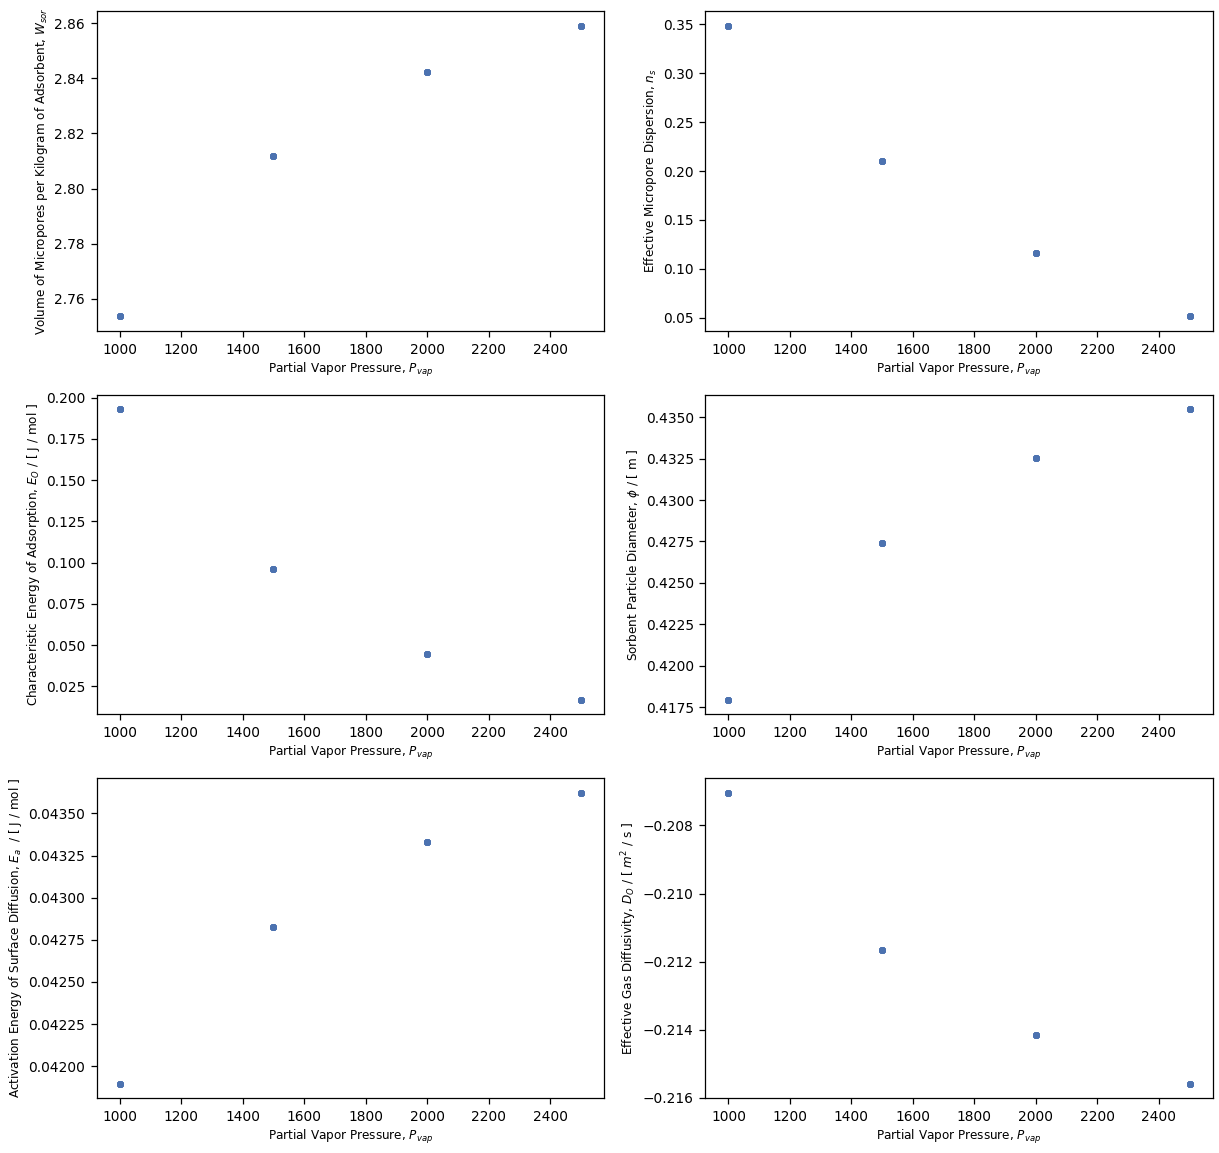

In [15]:
data = meta_df.T
ChartWo = np.array([data.Wo, data[256], data[257]])  # ChartWo[column][row] 
Chart_ads_k = np.array([data.ads_k, data[256], data[257]])  #
Chart_ads_ns = np.array([data.ads_ns, data[256], data[257]])  #
Chart_ads_cp = np.array([data.ads_cp, data[256], data[257]])  #
Chart_E0_beta = np.array([data.E0_beta, data[256], data[257]])  #
Chart_Ea = np.array([data.Ea, data[256], data[257]])  #
Chart_ads_dps = np.array([data.ads_dps, data[256], data[257]])  #
Chart_Du0 = np.array([data.Du0, data[256], data[257]])  #
x = data[256]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))


axis_font_size = 12
ax[0,0].scatter(x, data.Wo, label='a')
ax[0,0].set_xlabel('Partial Vapor Pressure, $P_{vap}$', fontsize=axis_font_size)
ax[0,0].set_ylabel('Volume of Micropores per Kilogram of Adsorbent, $W_{sor}$', fontsize=axis_font_size)

ax[0,1].scatter(x, data.ads_ns, label='b')
ax[0,1].set_xlabel('Partial Vapor Pressure, $P_{vap}$', fontsize=axis_font_size)
ax[0,1].set_ylabel('Effective Micropore Dispersion, $n_s$', fontsize=axis_font_size)

ax[1,0].scatter(x, data.E0_beta, label='c')
ax[1,0].set_xlabel('Partial Vapor Pressure, $P_{vap}$', fontsize=axis_font_size)
ax[1,0].set_ylabel('Characteristic Energy of Adsorption, $ E_O \beta$ / [ J / mol ]', fontsize=axis_font_size)

ax[1,1].scatter(x, data.ads_dps, label='d')
ax[1,1].set_xlabel('Partial Vapor Pressure, $P_{vap}$', fontsize=axis_font_size)
ax[1,1].set_ylabel('Sorbent Particle Diameter, $\phi$ / [ m ]', fontsize=axis_font_size)

ax[2,0].scatter(x, data.Ea, label='e')
ax[2,0].set_xlabel('Partial Vapor Pressure, $P_{vap}$', fontsize=axis_font_size)
ax[2,0].set_ylabel('Activation Energy of Surface Diffusion, $E_a$  / [ J / mol ]', fontsize=axis_font_size)

ax[2,1].scatter(x, data.Du0, label='f')
ax[2,1].set_xlabel('Partial Vapor Pressure, $P_{vap}$', fontsize=axis_font_size)
ax[2,1].set_ylabel('Effective Gas Diffusivity, $D_O$ / [ $m^2$ / s ]', fontsize=axis_font_size)

plt.show()